# T81-558: Applications of Deep Neural Networks
**Module 9: Regularization: L1, L2 and Dropout**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module Video Material

Main video lecture:

* [Part 9.1: L1 and L2 Regularization for Linear Regression](https://www.youtube.com/watch?v=xyymDGReKdY&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN&index=26)
* [Part 9.2: L1 and L2 Regularization for Keras](https://www.youtube.com/watch?v=CEFcwpBneFo&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN&index=27)
* [Part 9.3: Drop out Regularization for Keras](https://www.youtube.com/watch?v=JPqwyuK7bPg&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN&index=28)

Weekly video update:

* *Will be posted week of this class*

# Helpful Functions

You will see these at the top of every module.  These are simply a set of reusable functions that we will make use of.  Each of them will be explained as the semester progresses.  They are explained in greater detail as the course progresses.  Class 4 contains a complete overview of these functions.

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

# Regularization

Regularization is a technique that reduces overfitting, which occurs when neural networks attempt to memorize training data, rather than learn from it.  Humans are capable of overfitting as well.  Before we examine the ways that a machine accidentally overfits, we will first explore how humans can suffer from it.

Human programmers often take certification exams to show their competence in a given programming language.  To help prepare for these exams, the test makers often make practice exams available.  Consider a programmer who enters a loop of taking the practice exam, studying more, and then taking the practice exam again.  At some point, the programmer has memorized much of the practice exam, rather than learning the techniques necessary to figure out the individual questions.  The programmer has now overfit to the practice exam.  When this programmer takes the real exam, his actual score will likely be lower than what he earned on the practice exam.
 
 A computer can overfit as well.  Although a neural network received a high score on its training data, this result does not mean that the same neural network will score high on data that was not inside the training set.  Regularization is one of the techniques that can prevent overfitting. A number of different regularization techniques exist.  Most work by analyzing and potentially modifying the weights of a neural network as it trains.  


# Setup Data

We are going to look at linear regression to see how L1 and L2 regularization work.  The following code sets up the auto-mpg data for this purpose.

In [2]:
from sklearn.linear_model import LassoCV
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split 

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
# Do not need zscore standardization for linear regression
#encode_numeric_zscore(df, 'horsepower')
#encode_numeric_zscore(df, 'weight')
#encode_numeric_zscore(df, 'cylinders')
#encode_numeric_zscore(df, 'displacement')
#encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45) 
        

In [3]:
# Simple function to evaluate the coefficients of a regression
%matplotlib inline    
from IPython.display import display, HTML    

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))


# Linear Regression

To understand L1/L2 regularization, it is good to start with linear regression.  L1/L2 were first introduced for [linear regression](https://en.wikipedia.org/wiki/Linear_regression).  They can also be used for neural networks.  To fully understand L1/L2 we will begin with how they are used with linear regression.

The following code uses linear regression to fit the auto-mpg data set.  The RMSE reported will not be as good as a neural network.

Final score (RMSE): 2.9371578693389893


,coef,positive
origin-1,-1.448373,False
cylinders,-0.416543,False
horsepower,-0.007785,False
weight,-0.007473,False
displacement,0.024456,True
acceleration,0.138122,True
origin-3,0.629808,True
year,0.801274,True
origin-2,0.818565,True


Intercept: [-18.25751686]


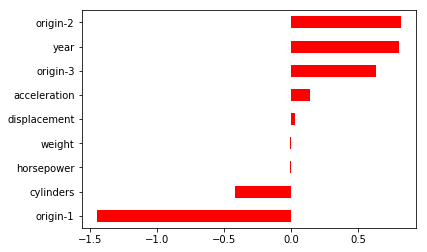

In [4]:
import sklearn

# Create linear regression
regressor = sklearn.linear_model.LinearRegression()

# Fit/train linear regression
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)


# L1 (Lasso) Regularization

L1 Regularization, also called LASSO (Least Absolute Shrinkage and Selection Operator) is should be used to create sparsity in the neural network. In other words, the L1 algorithm will push many weight connections to near 0.  When a weight is near 0, the program drops it from the network.  Dropping weighted connections will create a sparse neural network.

Feature selection is a useful byproduct of sparse neural networks. Features are the values that the training set provides to the input neurons.  Once all the weights of an input neuron reach 0, the neural network training determines that the feature is unnecessary.  If your data set has a large number of input features that may not be needed, L1 regularization can help the neural network detect and ignore unnecessary features.

L1 is implemented by adding the following error to the objective to minimize:

$$ E_1 = \alpha \sum_w{ |w| } $$

The following code demonstrates lasso regression.  Notice the effect of the coefficients compared to the previous section that used linear regression.

Final score (RMSE): 3.040905714035034


,coef,positive
origin-1,-1.264474,False
weight,-0.007458,False
horsepower,-0.002797,False
cylinders,-0.000000,True
origin-2,0.000000,True
origin-3,0.000000,True
displacement,0.013005,True
acceleration,0.113760,True
year,0.787195,True


Intercept: [-17.27126503]


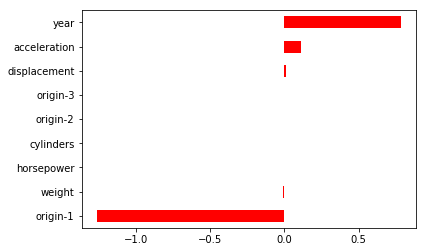

In [5]:
import sklearn
from sklearn.linear_model import Lasso

# Create linear regression
regressor = Lasso(random_state=0,alpha=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)


C:\Users\jeffh\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jeffh\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jeffh\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jeffh\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

(1e-08, 100000000.0)

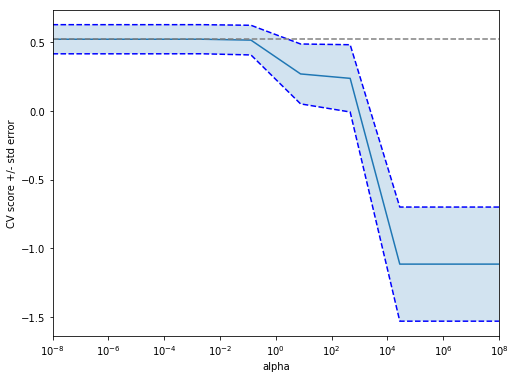

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

lasso = Lasso(random_state=42)
alphas = np.logspace(-8, 8, 10)

scores = list()
scores_std = list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_val_score(lasso, x, y, cv=n_folds, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# L2 (Ridge) Regularization

You should use Tikhonov/Ridge/L2 regularization when you are less concerned about creating a space network and are more concerned about low weight values.  The lower weight values will typically lead to less overfitting. 

$$ E_2 = \alpha \sum_w{ w^2 } $$

Like the L1 algorithm, the $\alpha$ value determines how important the L2 objective is compared to the neural network’s error.  Typical L2 values are below 0.1 (10%).  The main calculation performed by L2 is the summing of the squares of all of the weights.  The bias values are not summed.

The following code uses L2 with linear regression (Ridge regression):

Final score (RMSE): 2.941316843032837


C:\Users\jeffh\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.879966126163481e-09 / 5.960464477539063e-08
  RuntimeWarning)


,coef,positive
origin-1,-1.420841,False
cylinders,-0.409647,False
horsepower,-0.007524,False
weight,-0.007473,False
displacement,0.024128,True
acceleration,0.137986,True
origin-3,0.619194,True
year,0.800769,True
origin-2,0.801913,True


Intercept: [-18.23069191]


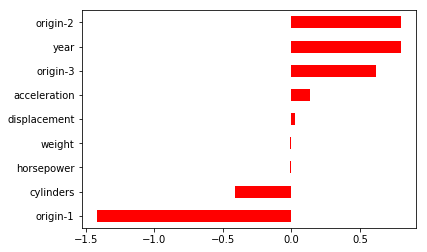

In [7]:
import sklearn
from sklearn.linear_model import Ridge

# Create linear regression
regressor = Ridge(alpha=1)

# Fit/train Ridge
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)


Final score (RMSE): 3.031985282897949


,coef,positive
origin-1,-0.938924,False
cylinders,-0.257568,False
weight,-0.007462,False
horsepower,-0.002896,False
displacement,0.017533,True
acceleration,0.131320,True
origin-3,0.369088,True
origin-2,0.458725,True
year,0.788913,True


Intercept: [-17.48009682]


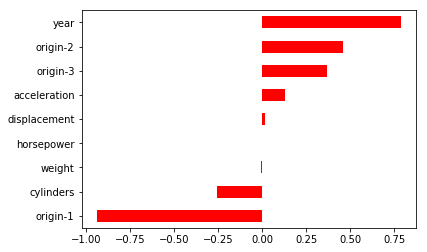

In [ ]:
import sklearn
from sklearn.linear_model import ElasticNet

# Create linear regression
regressor = ElasticNet(alpha=0.1, l1_ratio=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

# TensorFlow and L1/L2

L1 and L2 regularization are two common regularization techniques that can reduce the effects of overfitting (Ng, 2004).  Both of these algorithms can either work with an objective function or as a part of the backpropagation algorithm.  In both cases the regularization algorithm is attached to the training algorithm by adding an additional objective.  

Both of these algorithms work by adding a weight penalty to the neural network training.  This penalty encourages the neural network to keep the weights to small values.  Both L1 and L2 calculate this penalty differently.  For gradient-descent-based algorithms, such as backpropagation, you can add this penalty calculation to the calculated gradients.  For objective-function-based training, such as simulated annealing, the penalty is negatively combined with the objective score.

Both L1 and L2 work differently in the way that they penalize the size of a weight.  L1 will force the weights into a pattern similar to a Gaussian distribution; the L2 will force the weights into a pattern similar to a Laplace distribution, as demonstrated the following:

![L1 vs L2](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_9_l1_l2.png "L1 vs L2")

As you can see, L1 algorithm is more tolerant of weights further from 0, whereas the L2 algorithm is less tolerant.  We will highlight other important differences between L1 and L2 in the following sections.  You also need to note that both L1 and L2 count their penalties based only on weights; they do not count penalties on bias values.

Tensor flow allows [l1/l2 to be directly added to your network](http://tensorlayer.readthedocs.io/en/stable/modules/cost.html).

In [ ]:
########################################
# TensorFlow with L1/L2 for Regression
########################################
%matplotlib inline
from matplotlib.pyplot import figure, show
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.models import Sequential

path = "./data/"

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

df.drop('name',1,inplace=True)
missing_median(df, 'horsepower')
x,y = to_xy(df,"mpg")
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45)

model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(10, 
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01),activation='relu'))
# activity_regularizer can also be used.
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)
pred = model.predict(x_test)
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Using TensorFlow backend.


# Dropout Regularization

Srivastava, N., Hinton, G. E., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). [Dropout: a simple way to prevent neural networks from overfitting.](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) *Journal of Machine Learning Research*, 15(1), 1929-1958.

Most neural network frameworks implement dropout as a separate layer.  Dropout layers function as a regular, densely connected neural network layer.  The only difference is that the dropout layers will periodically drop some of their neurons during training.  You can use dropout layers on regular feedforward neural networks. In fact, they can also become layers in convolutional LeNET-5 networks like we studied in class 8.

The usual hyper-parameters for a dropout layer are the following:
* Neuron Count
* Activation Function
* Dropout Probability

The neuron count and activation function hyper-parameters work exactly the same way as their corresponding parameters in the dense layer type mentioned previously. The neuron count simply specifies the number of neurons in the dropout layer.  The dropout probability indicates the likelihood of a neuron dropping out during the training iteration.  Just as it does for a dense layer, the program specifies an activation function for the dropout layer.

![Dropout Regularization](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_9_dropout.png "Dropout Regularization")

A certain percentage neurons we be masked during each training step.  All neurons return after training is complete.  To make use of dropout in Keras use the **Dropout** layer and specify a dropout probability.  This is the percent of neurons to be dropped.  Typically this is a low value, such as 0.1.

Animation that shows how [dropout works](https://yusugomori.com/projects/deep-learning/dropout-relu)

In [ ]:
############################################
# TensorFlow with Dropout for Regression
############################################
%matplotlib inline
from matplotlib.pyplot import figure, show
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.models import Sequential

path = "./data/"

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

df.drop('name',1,inplace=True)
missing_median(df, 'horsepower')
x,y = to_xy(df,"mpg")
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45)

model = Sequential()
model.add(Dense(50, input_dim=x.shape[1]))
model.add(Dropout(0.01))
model.add(Dense(25, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)
pred = model.predict(x_test)
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

# Module 9 Assignment

You can find the first assignmeht here: [assignment 9](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/assignments/assignment_yourname_class9.ipynb)